In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import time
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings('ignore')

In [2]:
#load data
df = pd.read_csv('C:\\Git\\a3-predicting-car-price-Arun-vEDU\\Cars_a3.csv')

In [3]:
price_description = df["selling_price"].describe()
print(price_description)

min_price = df["selling_price"].min()
max_price = df["selling_price"].max()

print(f"Minimum selling price: {min_price}")
print(f"Maximum selling price: {max_price}")

count    8.128000e+03
mean     6.382718e+05
std      8.062534e+05
min      2.999900e+04
25%      2.549990e+05
50%      4.500000e+05
75%      6.750000e+05
max      1.000000e+07
Name: selling_price, dtype: float64
Minimum selling price: 29999
Maximum selling price: 10000000


In [4]:
#Step 1: Prepare data
# y is simply the selling price colomn
y = df["selling_price"]

# Covert into log scale
y_log = np.log(df["selling_price"])


# Using pd.cut to bin data into 4 classes
binned_data = pd.cut(y_log , bins=4) #now our y is four classes thus require multinomial


print(binned_data)

0       (11.761, 13.214]
1       (11.761, 13.214]
2       (11.761, 13.214]
3       (11.761, 13.214]
4       (11.761, 13.214]
              ...       
8123    (11.761, 13.214]
8124    (11.761, 13.214]
8125    (11.761, 13.214]
8126    (11.761, 13.214]
8127    (11.761, 13.214]
Name: selling_price, Length: 8128, dtype: category
Categories (4, interval[float64, right]): [(10.303, 11.761] < (11.761, 13.214] < (13.214, 14.666] < (14.666, 16.118]]


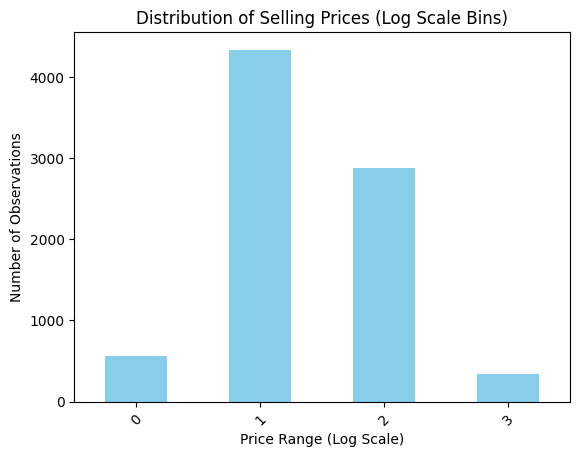

In [5]:
# Prepare data
# y is simply the selling price colomn
y = df["selling_price"]

# Covert into log scale
y_log = np.log(df["selling_price"])


binned_data = pd.cut(y_log, bins=4, labels=False)  # Creates 0, 1, 2, 3
# plot the values
# Value counts for each bin
bin_counts = pd.value_counts(binned_data)

# Bar plot
bin_counts.sort_index().plot(kind='bar', color='skyblue')
plt.title('Distribution of Selling Prices (Log Scale Bins)')
plt.xlabel('Price Range (Log Scale)')
plt.ylabel('Number of Observations')
plt.xticks(rotation=45)
plt.show()

In [6]:
# Add binned_data as a new column in the DataFrame
df['binned_price'] = binned_data

# Step 3: Prepare features and labels
X = df.drop(columns=['selling_price', 'binned_price']) 
y = df['binned_price']  # Original binned labels (0, 1, 2, 3)

print(binned_data)

0       1
1       1
2       1
3       1
4       1
       ..
8123    1
8124    1
8125    1
8126    1
8127    1
Name: selling_price, Length: 8128, dtype: int64


In [7]:
# Check the distribution of classes
class_distribution = binned_data.value_counts()

# Display the distribution of each class
print(class_distribution)

selling_price
1    4342
2    2884
0     565
3     337
Name: count, dtype: int64


In [8]:
# To check the data types of the columns
print(df.dtypes) 

name              object
year               int64
selling_price      int64
km_driven          int64
fuel              object
seller_type       object
transmission      object
owner             object
mileage           object
engine            object
max_power         object
torque            object
seats            float64
binned_price       int64
dtype: object


In [9]:
# my selected features are 'Max Power' and 'Year' from a1 and a2 assignments.

# Split the 'max_power' column by space
df[['max_power', 'max_power_unit']] = df['max_power'].str.split(' ', expand=True)

# Remove the 'max_power_unit' column
df = df.drop('max_power_unit', axis=1)
df.columns

# Convert 'max_power' to a numeric type
df['max_power'] = pd.to_numeric(df['max_power'])

# To check the data types of the columns
#print(df)
print(df.dtypes)

name              object
year               int64
selling_price      int64
km_driven          int64
fuel              object
seller_type       object
transmission      object
owner             object
mileage           object
engine            object
max_power        float64
torque            object
seats            float64
binned_price       int64
dtype: object


In [10]:
# X is my selected strong features
# I have selected 2 features "year" and "max_power"
# less features are better.
X = df[        ['year', 'max_power']        ]

In [11]:
#Split the data into train and test
# test set is 20% of our dataset.
# This is a medium size data set, that is why it is selected 80%  traning set and 20% test set 

from sklearn.model_selection import train_test_split
#  X is your feature set and binned_data is your target (with 4 classes)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
#check for null values in traning set,The .isna() method is used to detect missing values (not avalible) and count it
X_train[['year', 'max_power']].isna().sum()
#check for null values in test set, and count it
X_test[['year', 'max_power']].isna().sum()

year          0
max_power    49
dtype: int64

In [13]:
# max power has 167 missing values. So we can fill them with ratio, the distribution of the 'max_power' is skewed.
# X_train is  training dataset and 'max_power' contains missing values

# Step 1: Calculate the ratio of each unique value in 'max_power'
ratio = X_train['max_power'].value_counts(normalize=True)

# Step 2: Define a function to sample values based on these ratios
def fill_missing_values(column, value_distribution):
    missing_indices = column[column.isnull()].index  # Find indices where values are missing
    filled_values = np.random.choice(value_distribution.index, 
                                     size=len(missing_indices), 
                                     p=value_distribution.values)  # Sample from distribution
    
    # Fill the missing values with sampled values
    column.loc[missing_indices] = filled_values
    return column

# Step 3: Fill missing values in 'max_power' based on the ratio
X_train['max_power'] = fill_missing_values(X_train['max_power'], ratio)

# Now, X_train['max_power'] has the missing values filled based on the value distribution
print(X_train['max_power'].isnull().sum())  # This should return 0 (no missing values)

0


In [14]:
# Step 4: Fill missing values in 'max_power' in X_test using the same ratio as X_train
X_test['max_power'] = fill_missing_values(X_test['max_power'], ratio)

# Now, X_test['max_power'] should have the missing values filled based on the distribution from X_train
print(X_test['max_power'].isnull().sum())  # This should also return 0 (no missing values)

0


In [15]:
# I'm running the custom class for evaluate bast parameters with out mlflow. 
from collections import Counter
from imblearn.over_sampling import SMOTE
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid

# Step 1: Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Scaled X_train
X_test_scaled = scaler.transform(X_test)        # Scaled X_test

y_labels = y_train  # Assuming y_train contains the labels (0, 1, 2, 3)

# Step 2: Apply SMOTE to the scaled X_train
smote = SMOTE(random_state=42)
X_train_smote, y_labels_smote = smote.fit_resample(X_train_scaled, y_labels)  # Use the scaled X_train

# Check the class distribution after SMOTE
print("After SMOTE:", Counter(y_labels_smote))

# One-hot encode the labels
y_labels_smote_one_hot = pd.get_dummies(y_labels_smote, prefix='class')

# Step 3: Add intercept term AFTER SMOTE and scaling
intercept_train = np.ones((X_train_smote.shape[0], 1))  # Shape (m, 1)
X_train_with_intercept = np.concatenate((intercept_train, X_train_smote), axis=1)  # Shape (m, n + 1)

intercept_test = np.ones((X_test_scaled.shape[0], 1))  # Shape (m, 1)
X_test_with_intercept = np.concatenate((intercept_test, X_test_scaled), axis=1)  # Shape (m, n + 1)

# Logistic Regression class
class LogisticRegression:
    def __init__(self, k, n, method, alpha=0.1, max_iter=5000, use_penalty=False, penalty='ridge', lambda_=0.01):
        self.k = k  # Number of classes
        self.n = n  # Number of features
        self.alpha = alpha  # Learning rate
        self.max_iter = max_iter  # Maximum iterations
        self.method = method  # Optimization method: 'batch', 'minibatch', or 'sto'
        self.use_penalty = use_penalty  # Whether to use penalty (regularization)
        self.penalty = penalty  # Type of penalty ('ridge' for L2)
        self.lambda_ = lambda_  # Regularization strength
        self.W = np.random.rand(n + 1, k)  # Initialize weights

    def fit(self, X, Y):
        self.W = np.random.rand(self.n + 1, self.k)  # Initialize weights
        self.losses = []  # To store loss values
        
        if self.method == "batch":
            start_time = time.time()
            for i in range(self.max_iter):
                loss, grad = self.gradient(X, Y)
                self.losses.append(loss)
                self.W -= self.alpha * grad  # Update weights
                if i % 500 == 0:
                    print(f"Loss at iteration {i}: {loss}")
            print(f"Time taken: {time.time() - start_time}")
        
        elif self.method == "minibatch":
            start_time = time.time()
            batch_size = int(0.3 * X.shape[0])
            for i in range(self.max_iter):
                indices = np.random.choice(X.shape[0], size=batch_size, replace=False)  # Randomly select indices for the batch
                batch_X = X[indices]
                batch_Y = Y[indices]
                loss, grad = self.gradient(batch_X, batch_Y)
                self.losses.append(loss)
                self.W -= self.alpha * grad  # Update weights
                if i % 500 == 0:
                    print(f"Loss at iteration {i}: {loss}")
            print(f"Time taken: {time.time() - start_time}")
        
        elif self.method == "sto":
            start_time = time.time()
            for i in range(self.max_iter):
                idx = np.random.randint(X.shape[0])  # Randomly select an index
                X_train = X[idx, :].reshape(1, -1)  # Reshape for a single sample
                Y_train = Y[idx].reshape(1, -1)  # Reshape for a single sample
                loss, grad = self.gradient(X_train, Y_train)
                self.losses.append(loss)
                self.W -= self.alpha * grad  # Update weights
                if i % 500 == 0:
                    print(f"Loss at iteration {i}: {loss}")
            print(f"Time taken: {time.time() - start_time}")
        
        else:
            raise ValueError('Method must be one of the following: "batch", "minibatch", or "sto".')
        
    def gradient(self, X, Y):
        m = X.shape[0]  # Number of training examples
        h = self.h_theta(X, self.W)  # Hypothesis
        loss = -np.sum(Y * np.log(h)) / m  # Cross-entropy loss
        
        # Apply penalty if use_penalty is True
        if self.use_penalty and self.penalty == 'ridge':
            loss += (self.lambda_ / (2 * m)) * np.sum(np.square(self.W))  # Ridge penalty (L2)
        
        error = h - Y  # Error term
        grad = self.softmax_grad(X, error)
        
        # Apply gradient for penalty if use_penalty is True
        if self.use_penalty and self.penalty == 'ridge':
            grad += (self.lambda_ / m) * self.W  # Add Ridge gradient (L2)
        
        return loss, grad
        
    def softmax(self, theta_t_x):
        # Ensure input is a NumPy array
        theta_t_x = np.array(theta_t_x)
    
        # Perform softmax calculation
        exp_values = np.exp(theta_t_x - np.max(theta_t_x, axis=1, keepdims=True))
        return exp_values / np.sum(exp_values, axis=1, keepdims=True)

    def softmax_grad(self, X, error):
        return X.T @ error / X.shape[0]

    def h_theta(self, X, W):
        return self.softmax(X @ W)
    
    def predict(self, X_test):
            h = self.h_theta(X_test, self.W)  # Get the probabilities
            return np.argmax(h, axis=1)  # Return the predicted class labels directly

    def f1_score(self, y_true, y_pred, class_label):
        prec = self.precision(y_true, y_pred, class_label)
        rec = self.recall(y_true, y_pred, class_label)
        return 2 * (prec * rec) / (prec + rec) if (prec + rec) > 0 else 0

    def precision(self, y_true, y_pred, class_label):
        TP = np.sum((y_true == class_label) & (y_pred == class_label))
        FP = np.sum((y_true != class_label) & (y_pred == class_label))
        return TP / (TP + FP) if (TP + FP) > 0 else 0

    def recall(self, y_true, y_pred, class_label):
        TP = np.sum((y_true == class_label) & (y_pred == class_label))
        FN = np.sum((y_true == class_label) & (y_pred != class_label))
        return TP / (TP + FN) if (TP + FN) > 0 else 0

    def macro_f1(self, y_true, y_pred):
        classes = np.unique(y_true)
        f1_scores = [self.f1_score(y_true, y_pred, class_label) for class_label in classes]
        return np.mean(f1_scores)



# Step 5: Iterate over all combinations of hyperparameters

log_reg = LogisticRegression(k=4, n=X_train_scaled.shape[1],method ='batch', alpha=0.1, max_iter=5000, use_penalty=False, penalty='ridge', lambda_=0.01)
log_reg.fit(X_train_with_intercept, y_labels_smote_one_hot.values)  # Use the one-hot encoded labels
    
    

    # Make predictions on the test set
y_test_pred_labels = log_reg.predict(X_test_with_intercept)
   
    
    #  Evaluate F1 score
f1 = log_reg.macro_f1(y_test, y_test_pred_labels)
    
print(f"Macro f1: {f1}")



After SMOTE: Counter({1: 3443, 0: 3443, 2: 3443, 3: 3443})
Loss at iteration 0: 1.403064937732779
Loss at iteration 500: 0.49791496334888813
Loss at iteration 1000: 0.45854139524272874
Loss at iteration 1500: 0.4420962719505644
Loss at iteration 2000: 0.4332289382894197
Loss at iteration 2500: 0.42773532641551215
Loss at iteration 3000: 0.42401122081119563
Loss at iteration 3500: 0.4213220294955846
Loss at iteration 4000: 0.4192881493559967
Loss at iteration 4500: 0.41769526621310754
Time taken: 13.76772141456604
Macro f1: 0.6956379789214808


Inference

In [16]:
import pickle
import dill
# save the model to disk
filename = 'Car_classification.pkl'
pickle.dump(log_reg, open(filename, 'wb'))


# Save the model
with open('app.pkl', 'wb') as f:
    dill.dump((log_reg, scaler), f)

# Load the model
with open('app.pkl', 'rb') as f:
    model = dill.load(f)


Testing

In [17]:
import pickle
import numpy as np
from sklearn.preprocessing import StandardScaler


# Step 2: Load the model from the file
with open('Car_classification.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

print("Model loaded from Car_classification.pkl")


# Step 1: Prepare your new data
# Example of new data point (replace with your actual data)
new_data = np.array([[2000, 120]])  # Replace with actual values
new_data_scaled = scaler.transform(new_data)  # Scale the new data

# Step 2: Add the intercept term to the new data
intercept_new_data = np.ones((new_data_scaled.shape[0], 1))  # Shape (m, 1)
new_data_with_intercept = np.concatenate((intercept_new_data, new_data_scaled), axis=1)  # Shape (m, n + 1)

# Step 3: Predict the class of the new data
predicted_class_label = loaded_model.predict(new_data_with_intercept)

# Output the predicted class label
print(f"Predicted class label for the new data: {predicted_class_label}")



Model loaded from Car_classification.pkl
Predicted class label for the new data: [0]


In [18]:
import pickle
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Step 1: Bin the data using pd.cut and retrieve the bin edges
y_log = np.log(df["selling_price"])

# Using pd.cut to bin data into 4 classes
binned_data, bin_edges = pd.cut(y_log, bins=4, retbins=True)  # Returns both the binned data and the bin edges

# Convert the bin edges to the original selling price scale
bin_edges_original = np.exp(bin_edges)

print(f"Original price ranges for the bins: {bin_edges_original}")

# Now, you can continue with the rest of your prediction steps...

# Step 2: Load the model from the file
with open('Car_classification.pkl', 'rb') as file:
    loaded_model = pickle.load(file)

print("Model loaded from Car_classification.pkl")

# Step 3: Prepare your new data (replace with your actual data)
new_data = np.array([[2020, 120]])  # Replace with actual values
new_data_scaled = scaler.transform(new_data)  # Scale the new data

# Step 4: Add the intercept term to the new data
intercept_new_data = np.ones((new_data_scaled.shape[0], 1))  # Shape (m, 1)
new_data_with_intercept = np.concatenate((intercept_new_data, new_data_scaled), axis=1)  # Shape (m, n + 1)

# Step 5: Predict the class of the new data
predicted_class_label = loaded_model.predict(new_data_with_intercept)

# Output the predicted class label
print(f"Predicted class label for the new data: {predicted_class_label}")

# Step 6: Map the predicted class label to the original price range
predicted_class = predicted_class_label[0]  # Since it's an array, take the first (and only) value

# Get the corresponding price range for the predicted class
price_range = (bin_edges_original[predicted_class], bin_edges_original[predicted_class + 1])

# Output the predicted price range
print(f"The predicted class corresponds to the original price range: {price_range[0]:.2f} to {price_range[1]:.2f}")


Original price ranges for the bins: [   29825.23572178   128182.89725297   547713.4287198   2340327.8161826
 10000000.00000001]
Model loaded from Car_classification.pkl
Predicted class label for the new data: [2]
The predicted class corresponds to the original price range: 547713.43 to 2340327.82
